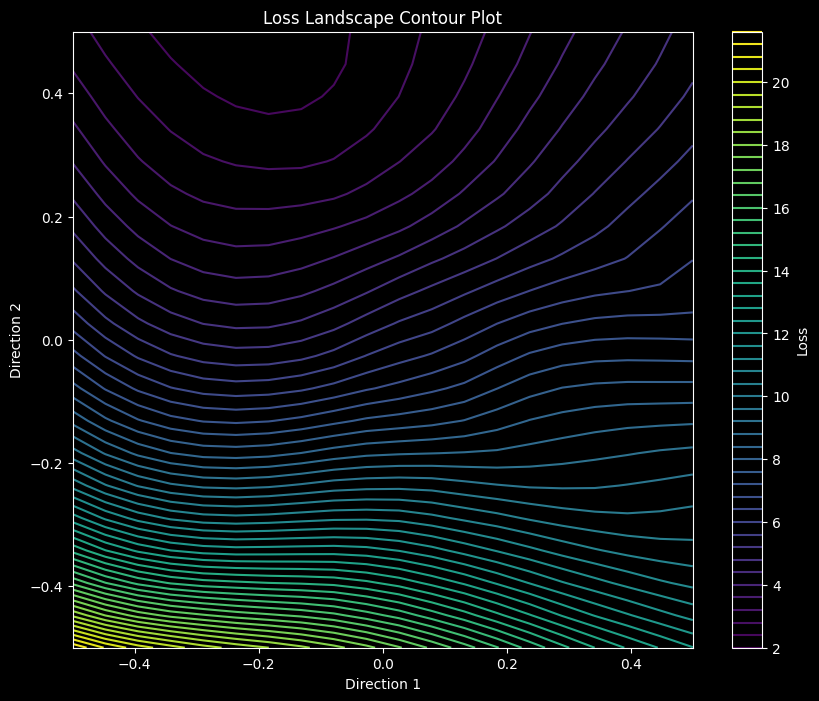

<Figure size 640x480 with 0 Axes>

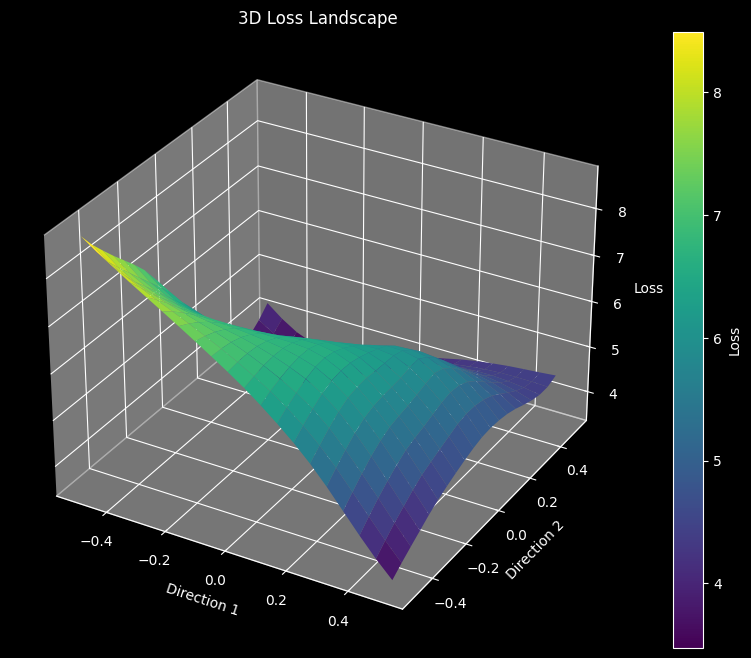

<Figure size 640x480 with 0 Axes>

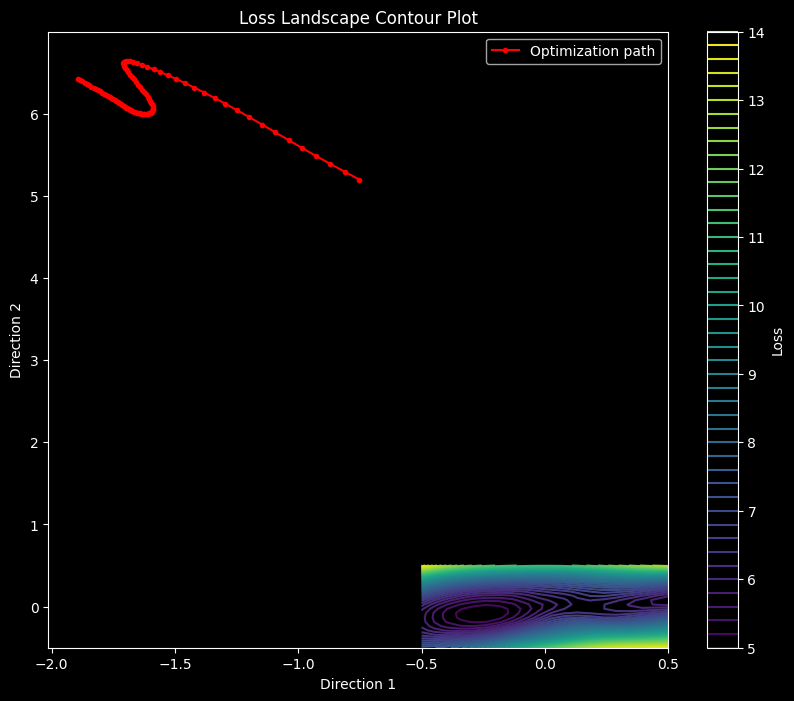

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
import seaborn as sns

class LossLandscapeVisualizer:
    def __init__(self, model, x_train, y_train):
        """
        Initialize the visualizer with a model and training data.
        
        Args:
            model: A tensorflow model
            x_train: Training features
            y_train: Training labels
        """
        self.model = model
        self.x_train = x_train
        self.y_train = y_train
        self.original_weights = [w.numpy() for w in model.trainable_weights]
        
    def compute_loss_on_grid(self, direction1, direction2, num_points=20, step_size=0.5):
        """
        Compute loss values on a 2D grid by perturbing weights in two directions.
        
        Args:
            direction1, direction2: Weight perturbation directions
            num_points: Number of points to evaluate in each direction
            step_size: Size of steps in weight space
            
        Returns:
            grid_x, grid_y: Meshgrid coordinates
            loss_values: Computed loss values at each point
        """
        # Create evaluation grid
        alpha = np.linspace(-step_size, step_size, num_points)
        beta = np.linspace(-step_size, step_size, num_points)
        grid_x, grid_y = np.meshgrid(alpha, beta)
        loss_values = np.zeros_like(grid_x)
        
        # Evaluate loss at each grid point
        for i in range(num_points):
            for j in range(num_points):
                # Compute weight perturbation
                weights = [w + (grid_x[i,j] * d1 + grid_y[i,j] * d2)
                          for w, d1, d2 in zip(self.original_weights, direction1, direction2)]
                
                # Set weights and compute loss
                self.model.set_weights(weights)
                loss_values[i,j] = self.model.evaluate(self.x_train, self.y_train, verbose=0)
                
        return grid_x, grid_y, loss_values
    
    def random_direction(self, scale=1.0):
        """Generate a random direction in weight space with the same shape as model weights."""
        return [scale * np.random.randn(*w.shape) for w in self.original_weights]
    
    def plot_2d_contour(self, direction1=None, direction2=None, num_points=20, step_size=0.5):
        """Create a 2D contour plot of the loss landscape."""
        if direction1 is None:
            direction1 = self.random_direction()
        if direction2 is None:
            direction2 = self.random_direction()
            
        grid_x, grid_y, loss_values = self.compute_loss_on_grid(
            direction1, direction2, num_points, step_size)
        
        plt.figure(figsize=(10, 8))
        plt.contour(grid_x, grid_y, loss_values, levels=50)
        plt.colorbar(label='Loss')
        plt.xlabel('Direction 1')
        plt.ylabel('Direction 2')
        plt.title('Loss Landscape Contour Plot')
        
    def plot_3d_surface(self, direction1=None, direction2=None, num_points=20, step_size=0.5):
        """Create a 3D surface plot of the loss landscape."""
        if direction1 is None:
            direction1 = self.random_direction()
        if direction2 is None:
            direction2 = self.random_direction()
            
        grid_x, grid_y, loss_values = self.compute_loss_on_grid(
            direction1, direction2, num_points, step_size)
        
        fig = plt.figure(figsize=(12, 8))
        ax = fig.add_subplot(111, projection='3d')
        surf = ax.plot_surface(grid_x, grid_y, loss_values, cmap='viridis')
        fig.colorbar(surf, label='Loss')
        ax.set_xlabel('Direction 1')
        ax.set_ylabel('Direction 2')
        ax.set_zlabel('Loss')
        ax.set_title('3D Loss Landscape')
        
    def plot_loss_trajectory(self, optimizer, epochs=100):
        """Visualize the optimization trajectory during training."""
        trajectory = []
        initial_weights = self.model.get_weights()
        
        # Custom training loop to track weights
        for epoch in range(epochs):
            with tf.GradientTape() as tape:
                predictions = self.model(self.x_train)
                loss = tf.reduce_mean(tf.square(self.y_train - predictions))
                
            grads = tape.gradient(loss, self.model.trainable_variables)
            optimizer.apply_gradients(zip(grads, self.model.trainable_variables))
            
            # Store current weights
            trajectory.append([w.numpy() for w in self.model.trainable_variables])
            
        # Project trajectory onto 2D space
        direction1 = self.random_direction()
        direction2 = self.random_direction()
        
        # Compute projected coordinates
        coord1 = []
        coord2 = []
        for weights in trajectory:
            diff = [w - ow for w, ow in zip(weights, self.original_weights)]
            c1 = sum(np.sum(d * dw) for d, dw in zip(direction1, diff))
            c2 = sum(np.sum(d * dw) for d, dw in zip(direction2, diff))
            coord1.append(c1)
            coord2.append(c2)
            
        # Plot trajectory on contour
        self.plot_2d_contour(direction1, direction2)
        plt.plot(coord1, coord2, 'r.-', label='Optimization path')
        plt.legend()

# Example usage
def create_simple_model():
    """Create a simple neural network for demonstration."""
    model = Sequential([
        Dense(10, activation='relu', input_shape=(2,)),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss=tf.keras.losses.MeanSquaredError())
    return model

# Generate synthetic data
np.random.seed(42)
X = np.random.randn(100, 2)
y = np.sum(X**2, axis=1, keepdims=True)

# Create model and visualizer
model = create_simple_model()
visualizer = LossLandscapeVisualizer(model, X, y)

# Generate various visualizations
visualizer.plot_2d_contour()
plt.figure()
visualizer.plot_3d_surface()
plt.figure()
visualizer.plot_loss_trajectory(tf.keras.optimizers.Adam(learning_rate=0.01))
plt.show()